In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer

In [3]:
# Load the datasets
movies_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
train_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

# Exploratory Data Analysis

In [4]:
# Display the first few rows of the movies dataset
movies_df.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [5]:
# Display the first few rows of the train dataset
train_df.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [6]:
# Display the first few rows of the test dataset
test_df.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [7]:
print("Key information and statistics of train dataset:")
print(train_df.info())
print('\n')
print(train_df.describe())

Key information and statistics of train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None


                                            movieid     reviewerName  \
count                                        162758           162758   
unique                                        16812             4482   
top     escape_the_terminator_tyler_durden_astonish  Sherri Morrison   
freq                                            708              962   

       isFrequentReviewer               reviewText sentiment  
count             

In [8]:
print("Key information and statistics of test dataset:")
print(test_df.info())
print('\n')
print(test_df.describe())

Key information and statistics of test dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB
None


                                            movieid     reviewerName  \
count                                         55315            55315   
unique                                        16786             4495   
top     escape_the_terminator_tyler_durden_astonish  Sherri Morrison   
freq                                            230              428   

       isTopCritic               reviewText  
count        55315                    52805  
unique           2                    52686  
top          False  Parental Content 

# Handling Missing & NaN Values

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [10]:
# test_df = test_df.replace(np.nan, "")
# train_df = train_df.replace(np.nan, "")
# movies_df = movies_df.replace(np.nan, "")

In [11]:
movies_df.drop_duplicates(subset='movieid', inplace=True)
movies_df.drop(columns=['soundType', 'distributor', 'rating', 'ratingContents', 'originalLanguage', 'boxOffice', 'runtimeMinutes', 'releaseDateStreaming', 'releaseDateTheaters'], inplace=True)
train = train_df.merge(movies_df, on='movieid', how='left')
train.dropna(subset=['reviewText'], inplace=True)
test = test_df.merge(movies_df, on='movieid', how='left')

In [12]:
# Check unique values in each column of train dataset
for column in train.columns:
    unique_values = train[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print("\n")

Unique values in column 'movieid':
['marvelous_pirate' 'tony_montana_frodo_baggins_v_rocky_balboa'
 'darth_vader_katniss_everdeen_sorcerer_donnie_darko' ...
 'dorothy_gale_luke_skywalker_luke_skywalker'
 'don_vito_corleone_witch_annie_hall' 'forrest_gump_fantasy_epic']


Unique values in column 'reviewerName':
['Benjamin Henry' 'Felicia Lopez' 'Mr. Charles Burgess' ... 'Gina Boyer'
 'David Small' 'Chad Mueller']


Unique values in column 'isFrequentReviewer':
[False  True]


Unique values in column 'reviewText':
['Henry Selick’s first movie since 2009’s Coraline. His fifth stop-motion masterpiece.'
 "With a cast that reads like the Vogue Oscar party guest list, Valentine's Day should have been can't-miss cinema instead of standard Hollywood schmaltz."
 "Creed II does not give us anything but another, slightly superior Rocky sequel. It wins on points. Just don't expect a knockout."
 ...
 'This fun, gentle comedy focuses mainly on themes that families can easily discuss around the dinner

In [13]:
# Check unique values in each column of train dataset
for column in test.columns:
    unique_values = test[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print("\n")

Unique values in column 'movieid':
['legend_marty_mcfly_oracle' 'terminator_katniss_everdeen_glimmer'
 'james_bond_labyrinth_gollum' ...
 'black_widow_frodo_baggins_tony_montana_mythical'
 'glorious_wondrous_the_terminator'
 'adventure_katniss_everdeen_mr._miyagi_enigma']


Unique values in column 'reviewerName':
['John Kim' 'Brian Chaney' 'Danielle Parker' ... 'Ann Morales'
 'Marcus Lopez DVM' 'Miss Melissa Carpenter']


Unique values in column 'isTopCritic':
[False  True]


Unique values in column 'reviewText':
['Green slowly cranks up the dread with style and even occasional shards of wit. It is more of a psychological thriller than the previous films, and all the better for it.'
 "Philip Noyce's direction is elegant and unforced, willing to let his admirable leads and the harsh beauty of the country speak for themselves."
 "It wouldn't do to say what path Maria ultimately takes... But that won't lessen the pleasure of the journey, or the stark scenery of Quebec's near north that se

In [14]:
# Check NaN values in each column of train dataset
train_nan_values = train.isna().sum()
train_nan_values

movieid                   0
reviewerName              0
isFrequentReviewer        0
reviewText                0
sentiment                 0
title                     0
audienceScore         12757
genre                  2346
director                  0
dtype: int64

In [15]:
# Check NaN values in each column of test dataset
test_nan_values = test.isna().sum()
test_nan_values

movieid             0
reviewerName        0
isTopCritic         0
reviewText       2510
title               0
audienceScore    4931
genre             920
director            0
dtype: int64

In [16]:
# # Iterate through rows with missing 'reviewText' in test dataset
# for index, row in test[test['reviewText'].isna()].iterrows():
#     movie_id = row['movieid']
    
#     # Check if the movie exists in the training dataset
#     if movie_id in train['movieid'].values:
#         train_movie = train[train['movieid'] == movie_id]
        
#         # Count positive and negative sentiment labels in the training reviews
#         positive_count = train_movie[train_movie['sentiment'] == 'POSITIVE'].shape[0]
#         negative_count = train_movie[train_movie['sentiment'] == 'NEGATIVE'].shape[0]
        
#         # Determine sentiment based on counts
#         if positive_count > negative_count:
#             test.at[index, 'reviewText'] = 'like most good best well very love funny too entertaining better lot emotional powerful everything interesting'
#         else:
#             test.at[index, 'reviewText'] = 'not like never bad nothing without old despite nothing dull fails unfortunately'
#     else:
#         test.at[index, 'reviewText'] = ''

# # Check NaN values in updated test dataset with filled 'reviewText' values
# test_nan_values = test.isna().sum()
# test_nan_values

In [17]:
# Renaming Column 'isTopCritic' to 'isFrequentReviewer' in the test dataset
test.rename(columns={'isTopCritic': 'isFrequentReviewer'}, inplace=True)

# Visualizing Key Statistics & Data Relationships

In [18]:
# Count the occurrences of each sentiment category in train data
print("Sentiment distribution:")
print(train['sentiment'].value_counts())

Sentiment distribution:
POSITIVE    104719
NEGATIVE     51592
Name: sentiment, dtype: int64


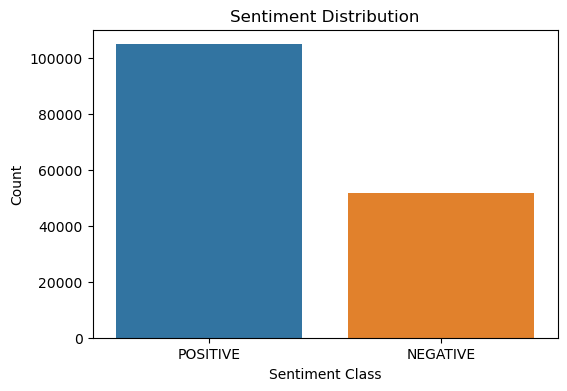

In [19]:
# Visualize the distribution of sentiment classes using a countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=train)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.show()

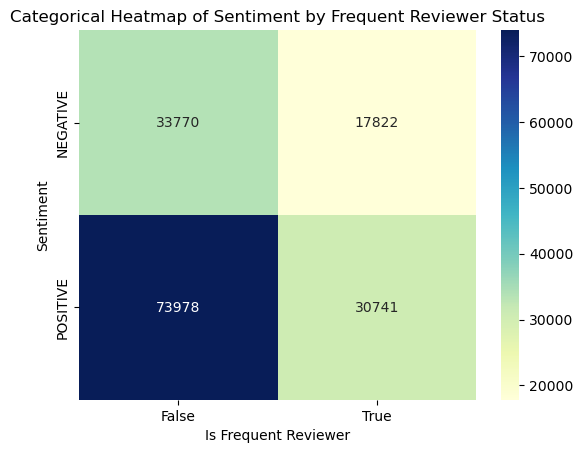

In [20]:
# Visualize the distribution of sentiment by frequent reviewer status using a categorical heatmap
ct = pd.crosstab(train['sentiment'], train['isFrequentReviewer'])
sns.heatmap(ct, annot=True, cmap='YlGnBu', fmt='d')
plt.xlabel('Is Frequent Reviewer')
plt.ylabel('Sentiment')
plt.title('Categorical Heatmap of Sentiment by Frequent Reviewer Status')
plt.show()

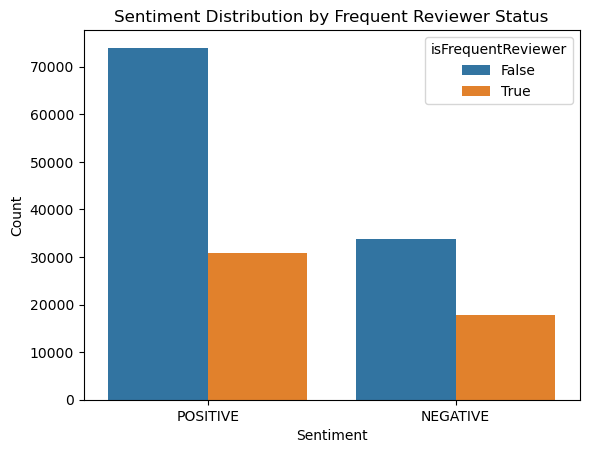

In [21]:
# Visualize the distribution of sentiment by frequent reviewer status
sns.countplot(x='sentiment', hue='isFrequentReviewer', data=train)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Frequent Reviewer Status')
plt.show()

# Data Preparation for Model Training & Prediction

In [22]:
grouped_data = train.groupby('movieid')



result = grouped_data.agg({
    'audienceScore': 'mean',
    'sentiment': lambda x: (x == 'NEGATIVE').sum()
})

# Reset index for visualization
result.reset_index(inplace=True)



In [23]:
result

,movieid,audienceScore,sentiment
0,adventure_captain_america_harry_potter,NaN,15
1,adventure_celestial_ellen_ripley_the,67.0,0
2,adventure_celestial_mystery_hannibal_lecter,53.0,3
3,adventure_celestial_oracle,42.0,14
4,adventure_donnie_darko,59.0,17
...,...,...,...
16407,zephyr_whisper_princess_leia,NaN,12
16408,zephyr_whisper_valley_elegant,NaN,1
16409,zephyr_witch_ferris_bueller,79.0,0
16410,zephyr_wolverine_vito_corleone,95.0,0


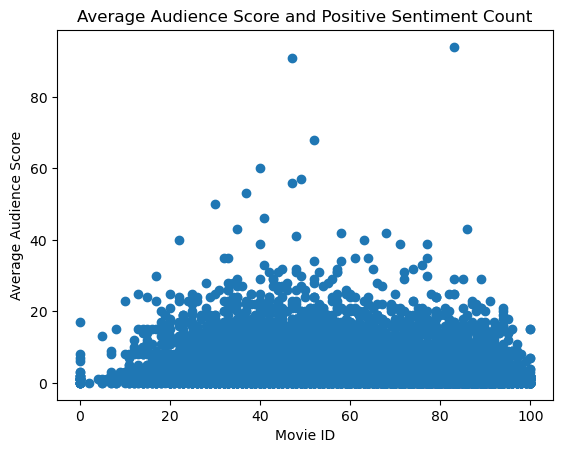

In [24]:
# Visualization
plt.scatter(result['audienceScore'], result['sentiment'])
plt.xlabel('Movie ID')
plt.ylabel('Average Audience Score')
plt.title("Average Audience Score and Positive Sentiment Count")
plt.show()

In [25]:
# Create a copy of the train dataset for model training
X = train.drop(columns=['sentiment', 'genre', 'director', 'reviewerName', 'title'])
y = train['sentiment']

X = X.fillna({'audienceScore': X['audienceScore'].mean(), 'reviewText': ''})

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X, y)

# Create a copy of the test dataset for prediction
X_test = test.drop(columns=['genre', 'director', 'reviewerName', 'title'])
X_test = X_test.fillna({'audienceScore': X_test['audienceScore'].mean(), 'reviewText': ''})
#The test dataset is now copied to X_test and is ready for prediction.

# MODEL 1

## **Multinomial Naive Bayes Classifier**

In [26]:
# #-------------------------------------------------------------------------------------------------------
# # Model Training with Hyperparameter Tuning
# #-------------------------------------------------------------------------------------------------------

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
# #         ('tf', TfidfVectorizer(stop_words='english'), 'reviewText')
#         ('cv', CountVectorizer(stop_words='english'), 'reviewText')
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', MultinomialNB())
# ])

# param_grid = {
#     'preprocessor__cv__lowercase': [True, False],
#     'preprocessor__cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'classifier__alpha': uniform(0.01, 2.0)  # Alpha parameter for MultinomialNB
# }

# random_search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_grid,
#     n_iter=10,  # Number of random combinations to try
#     scoring='f1_micro',
#     cv=5,  # Number of cross-validation folds
#     random_state=42,
#     n_jobs=-1  # Use all available CPU cores for parallel processing
# )

# random_search.fit(X_train, y_train_encoded)


# model = random_search.best_estimator_
# best_params = random_search.best_params_


# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# print("Best Hyperparameters:", best_params)

In [27]:
# #-------------------------------------------------------------------------------------------------------
# # Model Training with Best Hyperparameter
# #-------------------------------------------------------------------------------------------------------

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
#         ('tf', TfidfVectorizer(stop_words='english', ngram_range = (1, 1)), 'reviewText')
# #         ('cv', CountVectorizer(stop_words='english'), 'reviewText'),
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', MultinomialNB(alpha=0.47))
# ])

# model = pipeline.fit(X_train, y_train_encoded)

# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# MODEL 2
## **Gradient Boosting Classifier**

In [28]:
# #-------------------------------------------------------------------------------------------------------
# # Model Training with Hyperparameter Tuning
# #-------------------------------------------------------------------------------------------------------


# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
#         ('tf', TfidfVectorizer(stop_words='english'), 'reviewText')
# #         ('cv', CountVectorizer(stop_words='english'), 'reviewText')
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', GradientBoostingClassifier())
# ])

# param_dist = {
#     'preprocessor__tf__lowercase': [True, False],
#     'preprocessor__tf__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'classifier__max_depth': randint(3, 6),
# }

# random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, scoring='f1_micro', verbose=1, n_jobs=-1)

# random_search.fit(X_train, y_train_encoded)


# model = random_search.best_estimator_
# best_params = random_search.best_params_


# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# print("Best Hyperparameters:", best_params)


In [29]:
# #-------------------------------------------------------------------------------------------------------
# # Model Training with Best Hyperparameter
# #-------------------------------------------------------------------------------------------------------

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
#         ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), lowercase=True), 'reviewText')
# #         ('cv', CountVectorizer(stop_words='english'), 'reviewText'),
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', GradientBoostingClassifier(max_depth=2))
# ])

# model = pipeline.fit(X_train, y_train_encoded)

# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# MODEL 3
## **Logistic Regression**

In [30]:
# # -------------------------------------------------------------------------------------------------------
# # Model Training with Hyperparameter Tuning
# # -------------------------------------------------------------------------------------------------------

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
#         ('tf', TfidfVectorizer(stop_words='english'), 'reviewText')
# #         ('cv', CountVectorizer(stop_words='english'), 'reviewText')
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression())
# ])

# param_dist = {
#     'preprocessor__tf__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'classifier__C': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
#     'classifier__max_iter': [100, 500, 1000],
#     'classifier__solver': ['liblinear', 'lbfgs', 'saga']
# }


# random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, scoring='f1_micro', verbose=1, n_jobs=-1)

# random_search.fit(X_train, y_train_encoded)


# model = random_search.best_estimator_
# best_params = random_search.best_params_



# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# print("Best Hyperparameters:", best_params)

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209438 entries, 0 to 209437
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieid             209438 non-null  object 
 1   isFrequentReviewer  209438 non-null  bool   
 2   reviewText          209438 non-null  object 
 3   audienceScore       209438 non-null  float64
dtypes: bool(1), float64(1), object(2)
memory usage: 5.0+ MB


In [32]:
# -------------------------------------------------------------------------------------------------------
# Model Training with Best Hyperparameter
# -------------------------------------------------------------------------------------------------------

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

preprocessor = ColumnTransformer(
    transformers=
    [   
        ('scaler', StandardScaler(), ['audienceScore']),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid']),
        ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2)), 'reviewText')
#         ('cv', CountVectorizer(stop_words='english'), 'reviewText')
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=5000, C=7, solver='lbfgs'))
])


model = pipeline.fit(X_train, y_train_encoded)

y_train_pred_encoded = model.predict(X_train)
y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# MODEL 4
## **Stochastic Gradient Descent Classifier**

In [33]:
# # -------------------------------------------------------------------------------------------------------
# # Model Training with Hyperparameter Tuning
# # -------------------------------------------------------------------------------------------------------

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
#         ('tf', TfidfVectorizer(stop_words='english'), 'reviewText')
#         # ('cv', CountVectorizer(stop_words='english'), 'reviewText')
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', SGDClassifier(loss='hinge'))
# ])


# param_dist = {
#     'preprocessor__tf__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'classifier__max_iter': [100, 500, 1000, 1500, 2000],
#     'classifier__alpha': [0.00015, 0.0001, 0.00005]
# }


# random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='f1_micro', verbose=1, n_jobs=-1)

# random_search.fit(X_train, y_train_encoded)


# model = random_search.best_estimator_
# best_params = random_search.best_params_


# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)
# print("Best Hyperparameters:", best_params)

In [34]:
# #-------------------------------------------------------------------------------------------------------
# # Model Training with Best Hyperparameter
# #-------------------------------------------------------------------------------------------------------

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
#         ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1, 1)), 'reviewText')
# #         ('cv', CountVectorizer(stop_words='english'), 'reviewText')
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', SGDClassifier(loss='hinge', alpha=5e-05, max_iter=2000))
# ])


# model = pipeline.fit(X_train, y_train_encoded)

# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# MODEL 5
## **Random Forest Classifier**

In [35]:
# #-------------------------------------------------------------------------------------------------------
# # Model Training with Hyperparameter Tuning
# #-------------------------------------------------------------------------------------------------------

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
#         ('tf', TfidfVectorizer(stop_words='english'), 'reviewText')
#         # ('cv', CountVectorizer(stop_words='english'), 'reviewText')
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier())
# ])

# param_dist = {
#     'preprocessor__tf__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'classifier__n_estimators': randint(50, 150),
#     'classifier__max_depth': randint(2, 6),
#     'classifier__max_features': ['auto', 'sqrt', 'log2'],
#     'classifier__bootstrap': [True, False]
# }


# random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='f1_micro', verbose=1, n_jobs=-1)

# random_search.fit(X_train, y_train_encoded)


# model = random_search.best_estimator_
# best_params = random_search.best_params_


# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# print("Best Hyperparameters:", best_params)

In [36]:
# #-------------------------------------------------------------------------------------------------------
# # Model Training with Best Hyperparameter
# #-------------------------------------------------------------------------------------------------------

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

# preprocessor = ColumnTransformer(
#     transformers=
#     [
#         ('ohe', OneHotEncoder(handle_unknown='ignore'), ['movieid', 'reviewerName']),
#         ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1, 1)), 'reviewText')
# #         ('cv', CountVectorizer(stop_words='english'), 'reviewText')
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(bootstrap=True, max_depth=2, max_features='log2', n_estimators=111))
# ])


# model = pipeline.fit(X_train, y_train_encoded)

# y_train_pred_encoded = model.predict(X_train)
# y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)

# Summary of Model Performance

F1 Score (Micro) on Train Data: 0.9957791804734576
Classification Report on Train Data:
               precision    recall  f1-score   support

    NEGATIVE       0.99      1.00      1.00    104719
    POSITIVE       1.00      0.99      1.00    104719

    accuracy                           1.00    209438
   macro avg       1.00      1.00      1.00    209438
weighted avg       1.00      1.00      1.00    209438

Confusion Matrix on Train Data:
 [[104430    289]
 [   595 104124]]




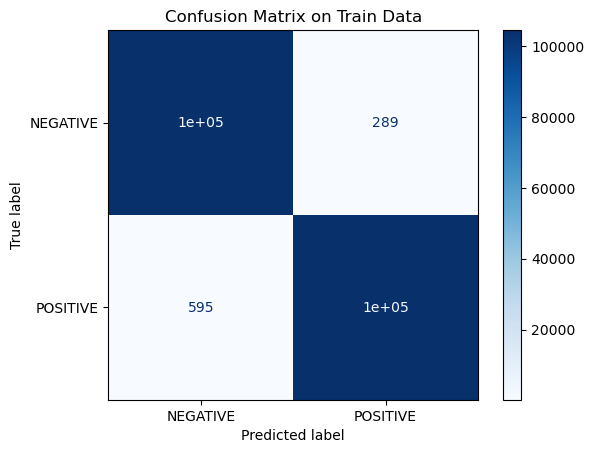

In [37]:
classification_rep_train = classification_report(y_train, y_train_pred)
f1_micro_train = f1_score(y_train, y_train_pred, average='micro')

print("F1 Score (Micro) on Train Data:", f1_micro_train)
print("Classification Report on Train Data:\n", classification_rep_train)

# Calculate confusion matrix
confusion_mat_train = confusion_matrix(y_train, y_train_pred, labels=label_encoder.classes_)

# Print confusion matrix
print("Confusion Matrix on Train Data:\n", confusion_mat_train)
print('\n')
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_train, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Train Data")
plt.show()

# Generating Predictions and Creating Submission File

In [38]:
y_pred_encoded = model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
submission_df = pd.DataFrame({"id": range(len(y_pred)), "sentiment": y_pred})
submission_df.to_csv("submission.csv", index=False)
print('Done')

Done
